`02_pandas2.ipynb`

## Grouping

In [1]:
import pandas as pd
import numpy as np

# 샘플 데이터: 온라인 쇼핑몰 주문 데이터
data = {
    '주문번호': [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010],
    '고객ID': ['A', 'B', 'A', 'C', 'B', 'A', 'D', 'C', 'B', 'D'],
    '상품카테고리': ['전자제품', '의류', '가구', '전자제품', '의류', '식품', '가구', '식품', '전자제품', '의류'],
    '구매액': [150000, 75000, 220000, 95000, 82000, 45000, 180000, 35000, 120000, 62000],
    '배송지역': ['서울', '부산', '서울', '인천', '서울', '부산', '인천', '서울', '부산', '인천'],
    '할인률': [0.05, 0.1, 0, 0.2, 0.1, 0, 0.05, 0.15, 0.2, 0]
}

df = pd.DataFrame(data)

In [2]:
# 기본 그룹 - 고객별 구매액 총합
df.groupby('고객ID')['구매액'].sum()

# 그룹 객체
id_group = df.groupby('고객ID')

# 그룹확인 (고객 ID들 그룹)
id_group.groups.keys()

# 특정 그룹 데이터 확인
id_group.get_group('A')

# 여러 Col으로 그루핑 (Series)
multi_group = df.groupby(['고객ID', '상품카테고리'])['구매액'].sum()
# DF 변환
multi_group.to_frame()

# 1개 col(구매액)에 집계함수 여러개 적용
df.groupby('고객ID')['구매액'].agg(['sum', 'mean', 'count', 'min', 'max'])

# n개 col에 m개 집계함수
df.groupby('고객ID').agg({
    '구매액': ['sum', 'mean', 'count'],
    '할인률': ['mean', 'max']
})


# 사용자 정의 집계 함수
def discount_amount(price):
    return (price * df.loc[price.index, '할인률']).sum()

df.groupby('고객ID')['구매액'].agg([
    # AS, function
    ('총구매액', 'sum'),
    ('평균구매액', 'mean'),
    ('할인총액', discount_amount),
])

,총구매액,평균구매액,할인총액
고객ID,,,
A,415000,138333.333333,7500.0
B,277000,92333.333333,39700.0
C,130000,65000.000000,24250.0
D,242000,121000.000000,9000.0


In [3]:
# 집계 함수 응용
import pandas as pd
import numpy as np

# 샘플 데이터
df = pd.DataFrame({
    '상품ID': ['A001', 'A002', 'A001', 'A003', 'A002', 'A004', 'A003', 'A001', 'A002', 'A004'],
    '판매일자': pd.date_range('2023-01-01', periods=10),
    '판매수량': [5, 3, 7, 2, 4, 6, 3, 8, 5, 4],
    '판매금액': [50000, 30000, 70000, 25000, 40000, 65000, 30000, 80000, 50000, 45000],
    '반품수량': [0, 1, 0, 0, 0, 2, 1, 0, 0, 1],
    '고객평점': [4.5, 3.8, 4.2, 5.0, 4.0, 3.5, 4.2, 4.8, 3.9, 4.1]
})

In [4]:
# 기본 집계
df.groupby('상품ID').agg({
    '판매수량': ['sum', 'mean', 'count'],
    '판매금액': ['sum', 'mean'],
    '반품수량': ['sum'],
    '고객평점': ['mean']
})

df

,상품ID,판매일자,판매수량,판매금액,반품수량,고객평점
0,A001,2023-01-01,5,50000,0,4.5
1,A002,2023-01-02,3,30000,1,3.8
2,A001,2023-01-03,7,70000,0,4.2
3,A003,2023-01-04,2,25000,0,5.0
4,A002,2023-01-05,4,40000,0,4.0
5,A004,2023-01-06,6,65000,2,3.5
6,A003,2023-01-07,3,30000,1,4.2
7,A001,2023-01-08,8,80000,0,4.8
8,A002,2023-01-09,5,50000,0,3.9
9,A004,2023-01-10,4,45000,1,4.1


In [5]:
# 커스텀 함수
# 총 판매수량 대비 반품수량 비율
def return_rate(x):
    # print(x, type(x))
    total_sold = df.loc[x.index, '판매수량'].sum()
    total_returned = df.loc[x.index, '반품수량'].sum()
    return total_returned / total_sold if total_sold > 0 else 0

df.groupby('상품ID').agg({
    '판매수량': ['sum', 'count'],
    '반품수량': ['sum', return_rate],
})

판매수량       반품수량            
      sum count  sum return_rate
상품ID                            
A001   20     3    0    0.000000
A002   12     3    1    0.083333
A003    5     2    1    0.200000
A004   10     2    3    0.300000

In [6]:
# 그룹별 순위 및 누적 계산
import pandas as pd
import numpy as np

# 샘플 데이터: 부서별 직원 실적
data = {
    '직원ID': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112],
    '이름': ['김철수', '이영희', '박민수', '정지영', '최동민', '강준호', '윤서연', '임태혁', '한미래', '송지원', '오민지', '홍길동'],
    '부서': ['영업', '개발', '영업', '인사', '개발', '영업', '개발', '인사', '영업', '개발', '영업', '인사'],
    '월별실적': [120, 85, 95, 110, 75, 135, 95, 110, 115, 90, 125, 100],
    '고객평가': [4.5, 3.8, 4.2, 4.7, 3.9, 4.8, 4.1, 4.3, 4.5, 4.0, 4.6, 4.2]
}

df = pd.DataFrame(data)
print("부서별 직원 실적 데이터:")
df

부서별 직원 실적 데이터:


,직원ID,이름,부서,월별실적,고객평가
0,101,김철수,영업,120,4.5
1,102,이영희,개발,85,3.8
2,103,박민수,영업,95,4.2
3,104,정지영,인사,110,4.7
4,105,최동민,개발,75,3.9
5,106,강준호,영업,135,4.8
6,107,윤서연,개발,95,4.1
7,108,임태혁,인사,110,4.3
8,109,한미래,영업,115,4.5
9,110,송지원,개발,90,4.0


In [7]:
# 그룹 내 순위 계산
dept_group = df.groupby('부서')

# 부서별 월별 실적 랭킹(높은사람부터)
df['부서순위_실적'] = dept_group['월별실적'].rank(method='dense', ascending=False)

# 동일 순위가 있을 경우의 처리 방식
# rank_methods = ['average', 'min', 'max', 'dense', 'first']
# for method in rank_methods:
#     col_name = f'순위_{method}'
#     df[col_name] = df.groupby('부서')['월별실적'].rank(method=method, ascending=False)

# df

df

,직원ID,이름,부서,월별실적,고객평가,부서순위_실적
0,101,김철수,영업,120,4.5,3.0
1,102,이영희,개발,85,3.8,3.0
2,103,박민수,영업,95,4.2,5.0
3,104,정지영,인사,110,4.7,1.0
4,105,최동민,개발,75,3.9,4.0
5,106,강준호,영업,135,4.8,1.0
6,107,윤서연,개발,95,4.1,1.0
7,108,임태혁,인사,110,4.3,1.0
8,109,한미래,영업,115,4.5,4.0
9,110,송지원,개발,90,4.0,2.0


In [8]:
1 == 1.0

True

In [9]:
# 누적 합계 및 누적 통계
# 부서별 누적 실적 합계  -> acummulate cummulate

df['부서별누적합계'] = df.groupby('부서')['월별실적'].cumsum()
df['부서별누적최대'] = df.groupby('부서')['월별실적'].cummax()

# 그룹별 비율계산
# 부서별 총 실적 대비 개인 실적 비율
df['부서총실적'] = dept_group['월별실적'].transform('sum')
df['부서기여도'] = df['월별실적'] / df['부서총실적']

# 복합응용
# 성과점수는 = 0.7 실적 + 0.3 (평가*20)
df['성과점수'] = df['월별실적'] * 0.7 + df['고객평가'] * 0.3 * 20
# 성과점수 별 랭킹
df['부서순위_성과'] = dept_group['성과점수'].rank(method='dense', ascending=False)

def cal_bonus(row):
    # 10% 기본보너스
    base_bonus = row['월별실적'] * 0.1
    rank = row['부서순위_성과'] 
    if rank == 1:
        return base_bonus * 1.5
    elif rank == 2:
        return base_bonus * 1.3
    elif rank == 3:
        return base_bonus * 1.1
    else:
        return base_bonus

# 랭킹별 보너스 지급 함수
df['성과급'] = df.apply(cal_bonus, axis=1)
df

,직원ID,이름,부서,월별실적,고객평가,부서순위_실적,부서별누적합계,부서별누적최대,부서총실적,부서기여도,성과점수,부서순위_성과,성과급
0,101,김철수,영업,120,4.5,3.0,120,120,590,0.203390,111.0,3.0,13.20
1,102,이영희,개발,85,3.8,3.0,85,85,345,0.246377,82.3,3.0,9.35
2,103,박민수,영업,95,4.2,5.0,215,120,590,0.161017,91.7,5.0,9.50
3,104,정지영,인사,110,4.7,1.0,110,110,320,0.343750,105.2,1.0,16.50
4,105,최동민,개발,75,3.9,4.0,160,85,345,0.217391,75.9,4.0,7.50
5,106,강준호,영업,135,4.8,1.0,350,135,590,0.228814,123.3,1.0,20.25
6,107,윤서연,개발,95,4.1,1.0,255,95,345,0.275362,91.1,1.0,14.25
7,108,임태혁,인사,110,4.3,1.0,220,110,320,0.343750,102.8,2.0,14.30
8,109,한미래,영업,115,4.5,4.0,465,135,590,0.194915,107.5,4.0,11.50
9,110,송지원,개발,90,4.0,2.0,345,95,345,0.260870,87.0,2.0,11.70


## 실습: 매출 데이터 그룹별 분석

In [10]:
# 실습: 매출 데이터 그룹별 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 매출 데이터 생성
np.random.seed(42)

# 날짜 생성 (2023년 전체)
dates = pd.date_range('2023-01-01', '2023-12-31')
n_records = 500

data = {
    '주문ID': np.arange(1001, 1001 + n_records),
    '주문일자': np.random.choice(dates, n_records),
    '고객ID': np.random.choice([f'CUST{i:03d}' for i in range(1, 101)], n_records),
    '상품ID': np.random.choice([f'PROD{i:03d}' for i in range(1, 51)], n_records),
    '카테고리': np.random.choice(['전자제품', '의류', '가구', '식품', '화장품', '도서', '스포츠'], n_records),
    '매출액': np.random.randint(10000, 500000, n_records),
    '수량': np.random.randint(1, 10, n_records),
    '지역': np.random.choice(['서울', '부산', '인천', '대구', '광주', '대전', '울산', '경기', '강원'], n_records),
    '결제방법': np.random.choice(['신용카드', '현금', '체크카드', '휴대폰', '계좌이체'], n_records),
    '고객등급': np.random.choice(['일반', '실버', '골드', 'VIP'], n_records)
}

df = pd.DataFrame(data)

In [11]:
df.head(3)

,주문ID,주문일자,고객ID,상품ID,카테고리,매출액,수량,지역,결제방법,고객등급
0,1001,2023-04-13,CUST002,PROD011,식품,384899,4,대구,현금,골드
1,1002,2023-12-15,CUST092,PROD004,도서,66985,7,대전,체크카드,VIP
2,1003,2023-09-28,CUST032,PROD015,가구,322213,9,강원,체크카드,일반


In [12]:
# 검색후 하기
# 날짜 정보 추출 -> 컬럼 추가 ['주문년월', '요일', '주'(1년중 몇번째 주)]
df['주문년월'] = df['주문일자'].dt.strftime('%Y-%m')
df['요일'] = df['주문일자'].dt.day_name()
df['주'] = df['주문일자'].dt.isocalendar().week

# 1/1 인 행들만 확인
df[ df['주문일자'] == '2023-01-01' ]

,주문ID,주문일자,고객ID,상품ID,카테고리,매출액,수량,지역,결제방법,고객등급,주문년월,요일,주
446,1447,2023-01-01,CUST090,PROD011,전자제품,267368,6,강원,체크카드,골드,2023-01,Sunday,52


In [13]:
# 단가 계산 
# 단가 컬럼 추가 (매출액/수량)
df['단가'] = df['매출액'] / df['수량']

In [14]:
# 카테고리별 매출 분석 
# 매출액 sum, mean, count / 수량 sum
df.groupby('카테고리').agg({
    '매출액': ['sum', 'mean', 'count'],
    '수량': ['sum']
})

매출액                        수량
           sum           mean count  sum
카테고리                                    
가구    19263561  267549.458333    72  348
도서    17826814  254668.771429    70  374
스포츠   17729088  268622.545455    66  332
식품    16816186  254790.696970    66  299
의류    17971859  253124.774648    71  359
전자제품  19526279  256924.723684    76  358
화장품   20600588  260766.936709    79  386

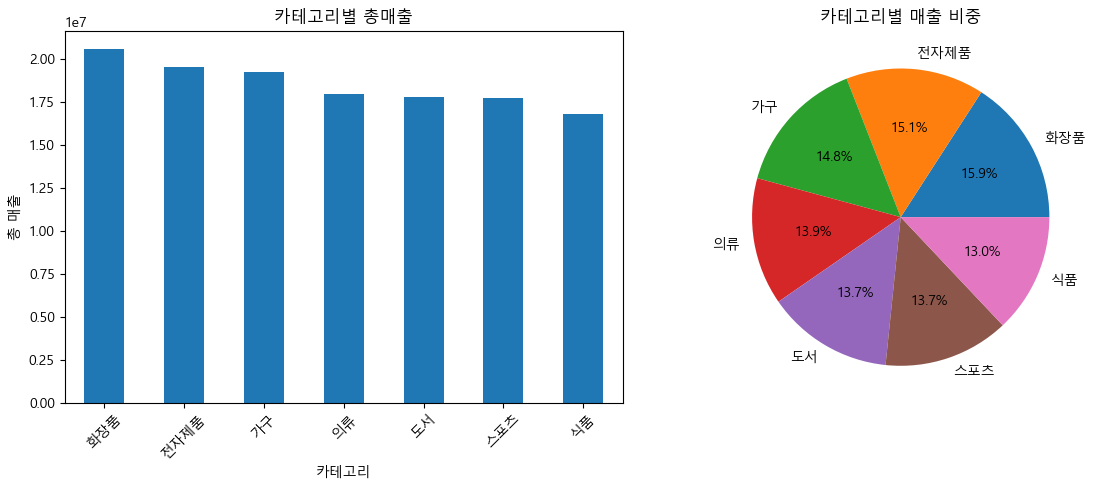

In [15]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 카테고리별 매출 비중 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
category_sum = df.groupby('카테고리')['매출액'].sum().sort_values(ascending=False)
category_sum.plot(kind='bar')
plt.title('카테고리별 총매출')
plt.ylabel('총 매출')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
category_sum.plot(kind='pie', autopct='%1.1f%%')
plt.title('카테고리별 매출 비중')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [16]:
# 월별 매출 트렌드
# '주문년월' 컬럼으로 매출액 sum, 주문ID count, 단가 mean
monthly_sales = df.groupby('주문년월').agg({
    '매출액': 'sum',
    '주문ID': ['count'],
    '단가': 'mean'
}).rename(columns={'주문ID': '주문건수'})

monthly_sales

,매출액,주문건수,단가
,sum,count,mean
주문년월,,,
2023-01,7786750,31,68573.324552
2023-02,13558838,47,83141.030344
2023-03,4820044,23,67224.537095
2023-04,13329098,49,97647.609208
2023-05,12825903,51,88883.442134
2023-06,10302473,44,64922.530177
2023-07,11575996,37,107918.450397
2023-08,11604378,47,69333.936651


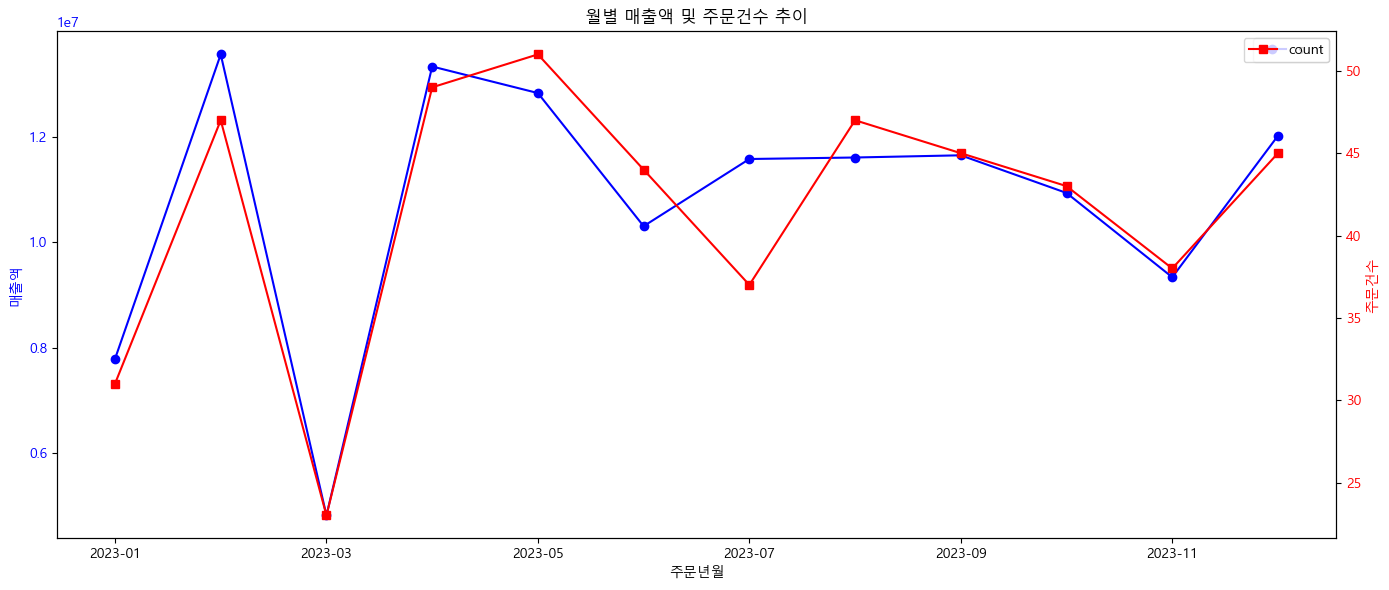

In [17]:
plt.figure(figsize=(14, 6))

# 매출액 추이
ax1 = plt.subplot(111)
monthly_sales['매출액'].plot(kind='line', marker='o', ax=ax1, color='blue')
ax1.set_title('월별 매출액 및 주문건수 추이')
ax1.set_ylabel('매출액', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 주문건수 추이 (보조 축)
ax2 = ax1.twinx()
monthly_sales['주문건수'].plot(kind='line', marker='s', ax=ax2, color='red')
ax2.set_ylabel('주문건수', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()


In [18]:
# 지역 & 카테고리별 매출 분석

# uunstack -> 다중인덱스 구조를 가로(열)로 펼쳐서 재구조화 함 : Index -> Col
regional_df = df.groupby(['지역', '카테고리'])['매출액'].sum().unstack()
regional_df

카테고리,가구,도서,스포츠,식품,의류,전자제품,화장품
지역,,,,,,,
강원,2567149,2229004,3236879,1546551,1961318,3064388,2350914
경기,1845589,1547956,2396558,2700479,3636189,2385742,3001775
광주,2583543,3290899,1543411,2609787,2337267,1158681,1920285
대구,2068333,1395664,1997663,1527438,2030142,2824580,2990911
대전,2806642,1400616,1817291,2557407,1321115,1665455,2186323
부산,1598356,1128322,1256823,749149,1827427,1714636,2565236
서울,2302258,2822680,2305854,1513749,2568012,1945582,1193348
울산,1396916,2365056,1497102,1385252,228601,1897187,2025993
인천,2094775,1646617,1677507,2226374,2061788,2870028,2365803


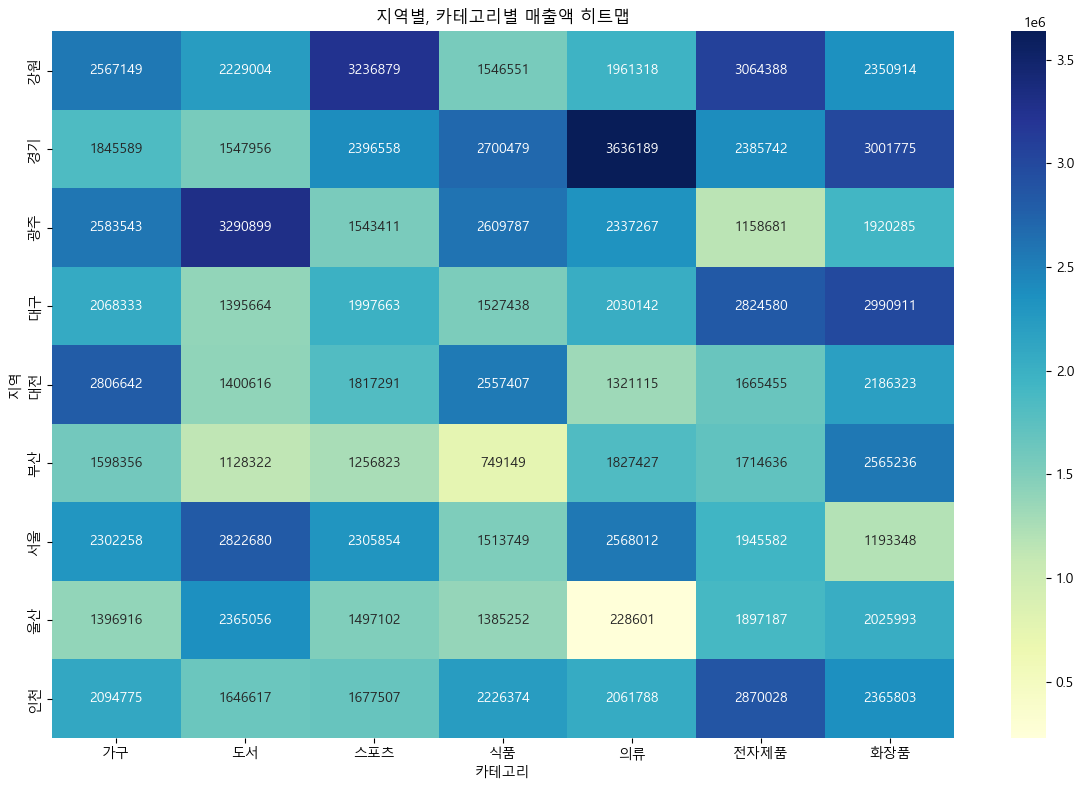

In [19]:
# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(regional_df, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('지역별, 카테고리별 매출액 히트맵')
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_31384\259756578.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_grade_sales = df.groupby(['요일', '고객등급'])['매출액'].sum().unstack()


<Figure size 1400x700 with 0 Axes>

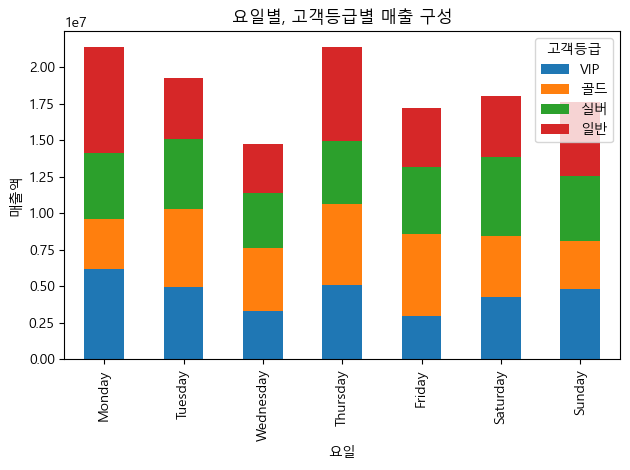

In [20]:
# 요일별 고객 등급별 매출 패턴

# 요일의 순서 지정
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['요일'] = pd.Categorical(df['요일'], categories=day_order, ordered=True)

day_grade_sales = df.groupby(['요일', '고객등급'])['매출액'].sum().unstack()

# 시각화
plt.figure(figsize=(14, 7))
day_grade_sales.plot(kind='bar', stacked=True)
plt.title('요일별, 고객등급별 매출 구성')
plt.ylabel('매출액')
plt.legend(title='고객등급')
plt.tight_layout()
plt.show()

In [21]:
# 결제방법별 분석 및 고객 행동 (매출액-sum mean count, 단가-mean)

total_sales = df['매출액'].sum()

def ratio(x):
    return x.sum() / total_sales * 100

payment_stats = df.groupby('결제방법').agg({
    '매출액': ['sum', 'mean', 'count', ratio],
    '단가': ['mean']
})

payment_stats

매출액                                            단가
           sum           mean count      ratio          mean
결제방법                                                        
계좌이체  26376866  251208.247619   105  20.331440  81029.835393
신용카드  25514730  260354.387755    98  19.666900  89773.784973
체크카드  26536652  260163.254902   102  20.454603  66063.697837
현금    25579043  272117.478723    94  19.716473  81782.442815
휴대폰   25727084  254723.603960   101  19.830584  84024.975216

In [22]:
# .nunique -> Series에서 고유한 값 개수 / DF 는 모든 컬럼에 고유한 값 개수

In [23]:
# 고객id 별 구매 패턴 (매출액 sum mean count, 구매한 고유 상품 수, 구매한 고유 카테고리 수)

def get_uniq_count(x):
    return x.nunique()

df.groupby('고객ID').agg({
    '매출액': ['sum', 'mean', 'count'],
    '상품ID': 'nunique',  # 위아래는 같다
    '카테고리': get_uniq_count,
}).sort_values([('매출액', 'sum'), ('상품ID', 'nunique')], ascending=False).head(3)

# sort_values(['a', 'b'])  => ORDER BY a, b => 단일 인덱스 컬럼
# sort_values([('a', 'sum'), ('b')])  => Col 'a', Agg 'sum' 값을 기준으로 정렬

매출액                         상품ID           카테고리
             sum           mean count nunique get_uniq_count
고객ID                                                        
CUST092  2814587  255871.545455    11      11              5
CUST017  2814138  281413.800000    10      10              6
CUST005  2709222  338652.750000     8       8              5

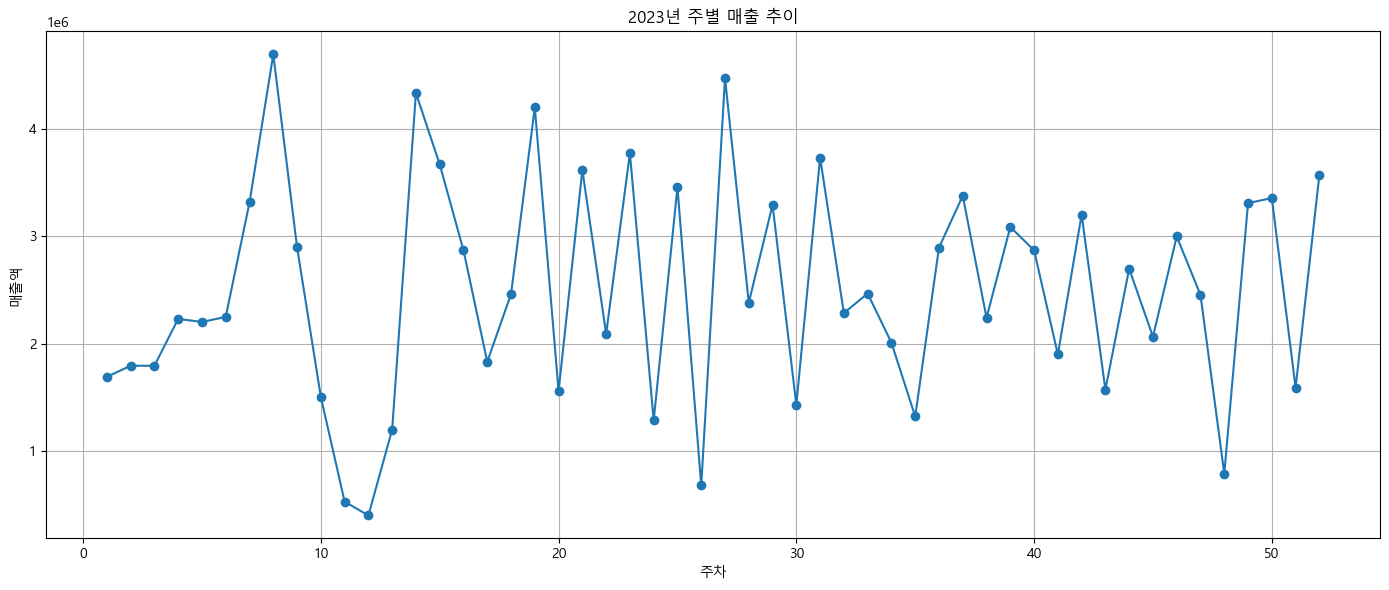

In [24]:
# 주별 매출 추이
weekly_sales = df.groupby('주')['매출액'].sum()

plt.figure(figsize=(14, 6))
weekly_sales.plot(kind='line', marker='o')
plt.title('2023년 주별 매출 추이')
plt.xlabel('주차')
plt.ylabel('매출액')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

weekly_sales = df.groupby(['주문년월', '주'])['매출액'].sum().reset_index()
weekly_sales = weekly_sales.sort_values(['주문년월', '주'])

# .pct_change()는 바로 이전 행과의 비율 차이를 계산
# fillna(0)으로 첫 주의 결측치는 0으로 처리 (전주 없으니까 0으로)
weekly_sales['매출증감률'] = weekly_sales['매출액'].pct_change().fillna(0)

weekly_sales

,주문년월,주,매출액,매출증감률
0,2023-01,1,1693663,0.000000
1,2023-01,2,1796630,0.060795
2,2023-01,3,1796731,0.000056
3,2023-01,4,2232358,0.242455
4,2023-01,52,267368,-0.880231
5,2023-02,5,2203467,7.241327
6,2023-02,6,2250272,0.021242
7,2023-02,7,3313923,0.472677
8,2023-02,8,4689983,0.415236
9,2023-02,9,1101193,-0.765203


In [26]:
# 매출 TOP 10 상품

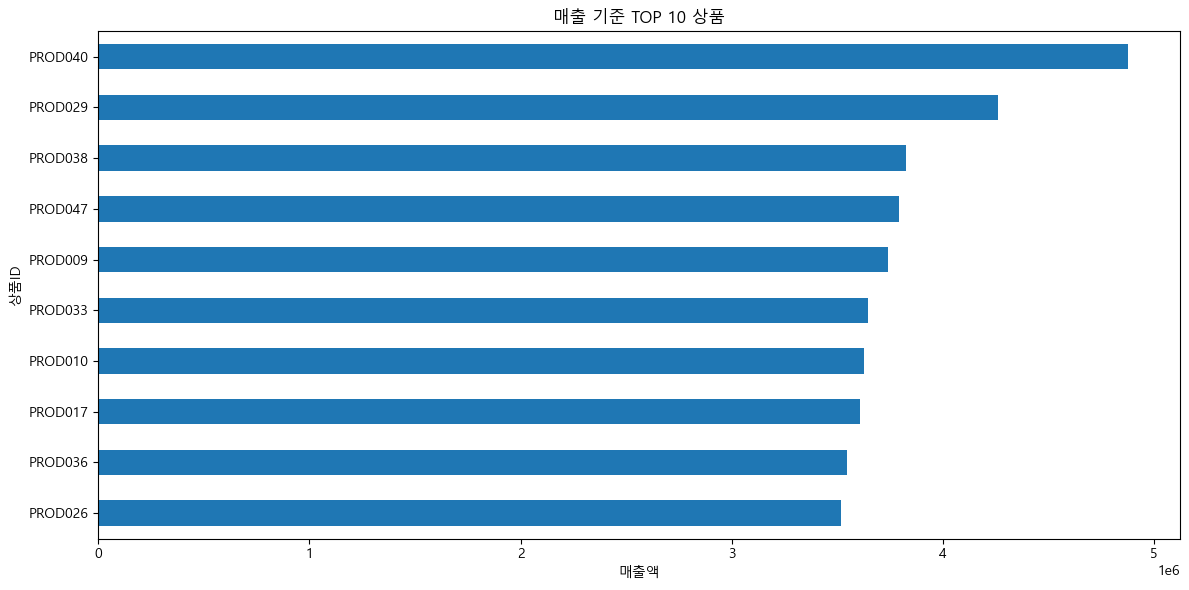

In [27]:
# 정렬 -> 위 10개
df.groupby('상품ID')['매출액'].sum().sort_values(ascending=False).head(10)

# 애초에 상위 10개만 가져와
top_products = df.groupby('상품ID')['매출액'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
top_products.sort_values().plot(kind='barh')
plt.title('매출 기준 TOP 10 상품')
plt.xlabel('매출액')
plt.tight_layout()
plt.show()